# IMAGEN Preprocessing #

## Table of Contents: ##
* [Outline](#outline)
* [Summary Stats for MID and SST Params](#summary stats for mid and sst params)
* [Mean Shift and Normalize](#mean shift and normalize)
* [Shuffle Test](#Shuffle Test)
* [Missing Data: Age 14](#missing data age 14)
* [Impute Features](#impute features)
* [Clean Up Features](#clean up features)

## Outline <a class="anchor" id="outline"></a>
**The following should be determined in this file:**
- What data exists, what subset is/ shoudl be used, and its raw state.
- How much needs to be interpolated or removed, how, and what other QC needs to be done.
    - How important statistics of the data are changed by these processes.
- What analyses make the most sense, and what we roughly expect from them

**It also includes...**
- Attempted reproductions of others' work
- Sanity checks on work done here and on the data

**Actual steps in achieving these goals include:**
- Stably inducting and partitioning the data
- 

## General Config
This is misc. stuff that gets used in the analysis below.

In [1]:
show_views <- FALSE  # Toggle slice views throughout
shuffle    <- FALSE  # Shuffle data for shuffle testing
re_read    <- FALSE  # Re-read the data
re_imp     <- FALSE  # Re-impute the data

library(ggplot2)
library(reshape2)
library(mice)

## Read in Subject Data ##

In [2]:
options(width=100)

In [3]:
# Actually read all the files: (Time consuming!)
if (re_read) {
    source('import_data.r')
    data <- import_data()
    saveRDS(data,'raw_data.rds')
} else {
    # Read saved R data file:
    data  <- readRDS('raw_data.rds')
    nsubj <- nrow(data$raw)
}

In [4]:
# View into data
if(show_views){
    view_rows <- c(1:5, (nsubj-5):nsubj)
    data$raw[view_rows,c('mu_targ_dur_co_14', 'mu_targ_left_co_14',  'mu_rewarded_co_14', 
           'mu_high_rewarded_co_14', 'mu_int_14',
           'sig_targ_dur_co_14','sig_targ_left_co_14','sig_rewarded_co_14',
           'sig_high_rewarded_co_14')]
}

## Standard Deviations of STN Activity

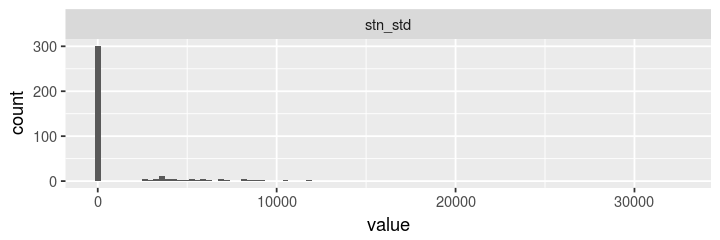

In [5]:
options(repr.plot.width=6, repr.plot.height=2)
ggplot(melt(data$raw['stn_std'], id.vars = NULL), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=100, na.rm=TRUE)

## Summary Stats for MID and SST Params  <a class="anchor" id="summary stats for mid and sst params"></a> ##

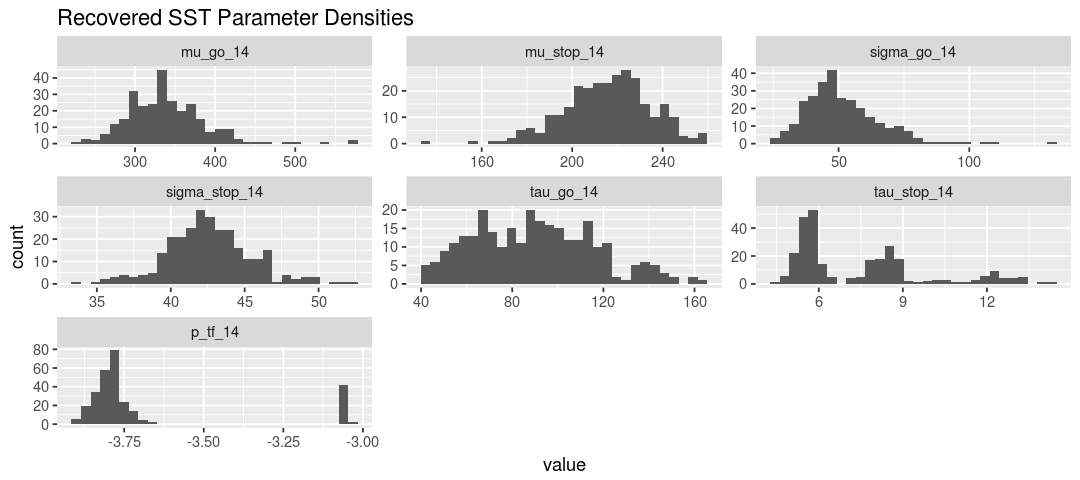

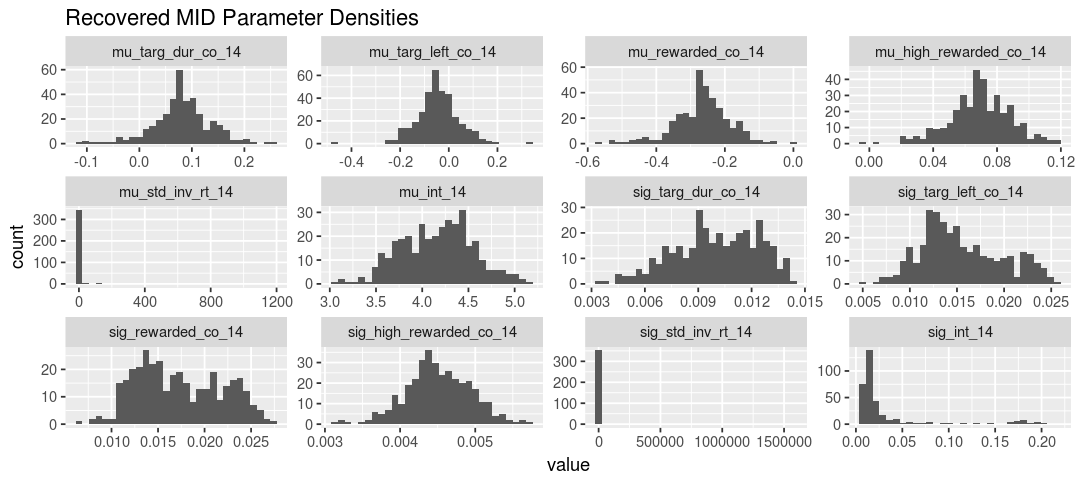

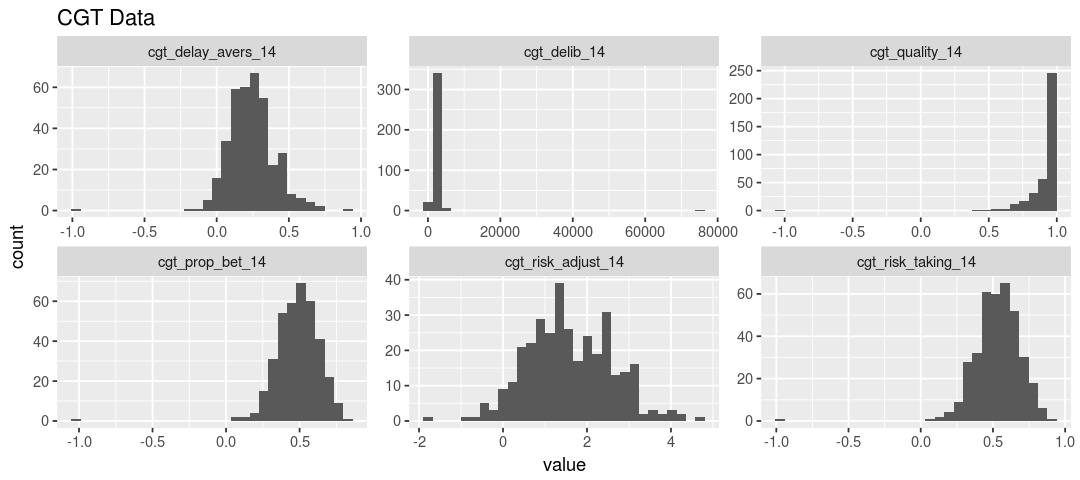

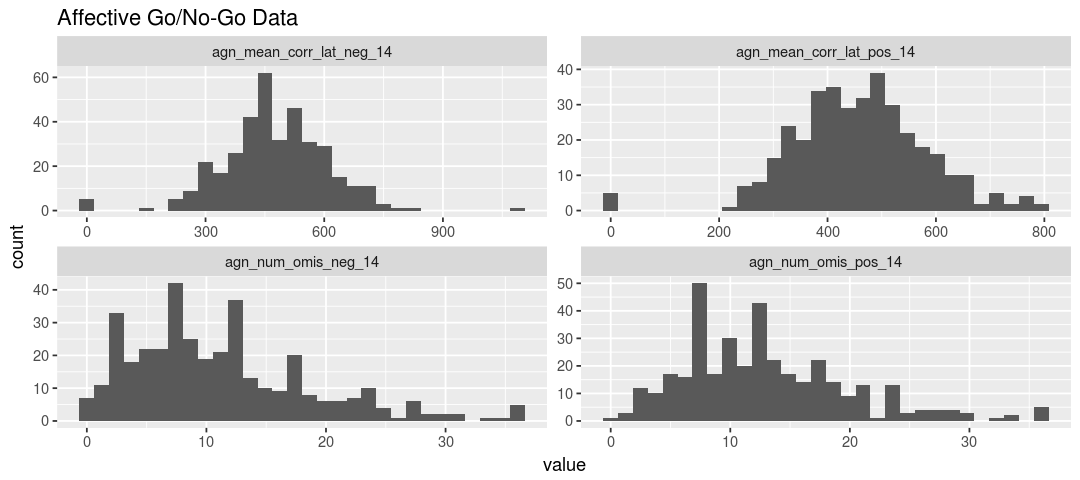

No id variables; using all as measure variables


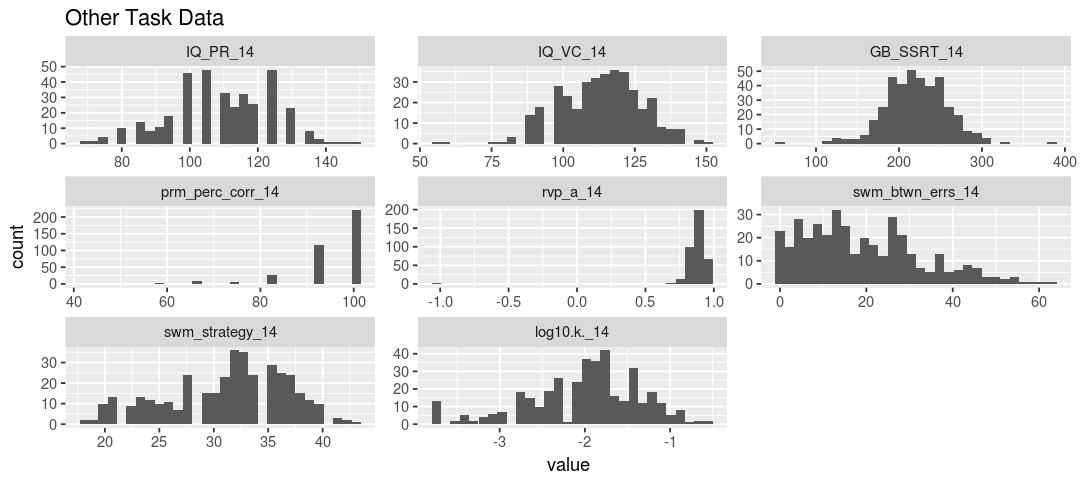

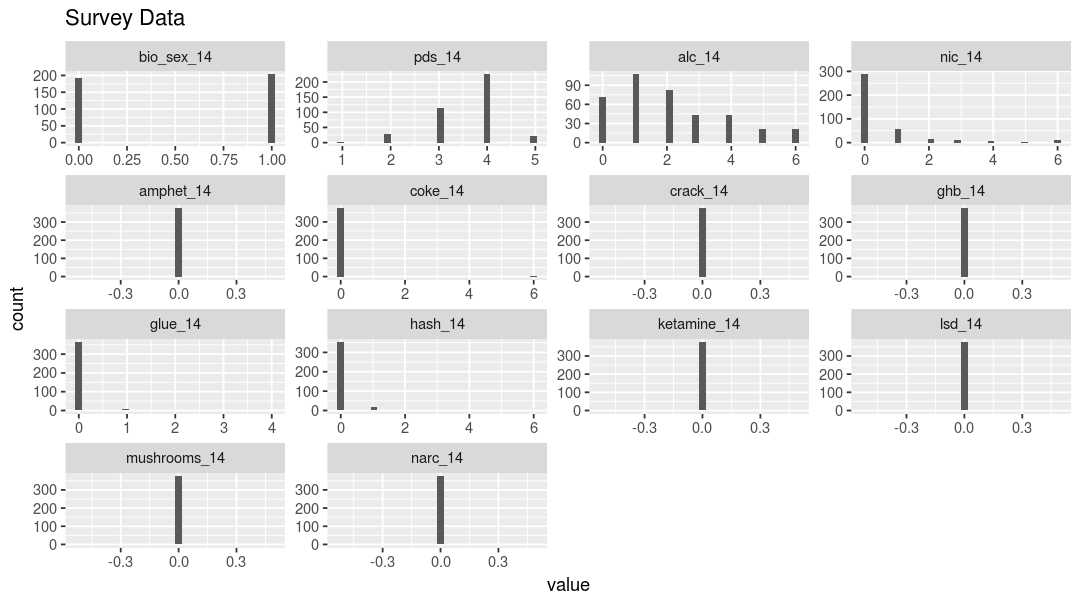

In [6]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot( melt(data$raw[data$sst_names], id.vars=NULL), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=30, na.rm=TRUE) + ggtitle("Recovered SST Parameter Densities")
ggplot( melt(data$raw[data$mid_names], id.vars=NULL), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=30, na.rm=TRUE) + ggtitle("Recovered MID Parameter Densities")
ggplot( melt(data$raw[data$cgt_names], id.vars=NULL), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=30, na.rm=TRUE) + ggtitle("CGT Data")
ggplot( melt(data$raw[data$agn_names], id.vars=NULL), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=30, na.rm=TRUE) + ggtitle("Affective Go/No-Go Data")
ggplot( melt(data$raw[data$msc_names], id.vars=NULL), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=30, na.rm=TRUE) + ggtitle("Other Task Data")

options(repr.plot.width=9, repr.plot.height=5)
ggplot( melt(data$raw[data$survey_names_14]), aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram(bins=30, na.rm=TRUE) + ggtitle("Survey Data")

## General Clean-up / QC <a class="anchor" id="Outlier Removal"></a> ##
Because there are some obviously bad (wrong) numbers in here. The exceptions list keeps stuff that looks fine from getting removed.

In [7]:
# Bad STN data:
bad_stn_msk <- !is.na(data$raw['stn_std']) & data$raw['stn_std'] > 50

print(c('Num bad stn data being dropped:', sum(bad_stn_msk)))
#data$raw[c('Subject','stn_std')][bad_stn_msk,]
data$raw['stn_std'][!is.na(data$raw['stn_std']) & data$raw['stn_std'] > 100,] <- NA

source('remove_outliers.r')
stdev_threshold <- 4

exceptions <- c('nic_14', 'prm_perc_cor_14'     , 'agn_total_omissions_negative_18',
                'agn_total_omissions_neutral_18', 'agn_total_omissions_positive_18')
check_flds <- setdiff(c(data$cgt_names, data$agn_names, data$mid_names, data$sst_names, data$msc_names, 'stn_std'),exceptions)

data$raw <- remove_outliers(data$raw, check_flds, stdev_threshold)

# Remove the wierd negative one values from the continuous task variables.
data$raw[data$task_names_14][data$raw[data$task_names_14] == -1] <- NA
data$raw[data$task_names_18][data$raw[data$task_names_18] == -1] <- NA

# Drop columns with all zeros, since they're uninformative.
raw_cols <- colnames(data$raw)
data$raw <- data$raw[, colSums(data$raw != 0, na.rm=TRUE) > 0]

# Drop some other features that are suspect
drop_list <- c('sig_int_14', 'sig_std_inv_rt_14', 'mu_std_inv_rt_14', 'p_tf_14', 'tau_stop_14')
data$raw  <- data$raw[, !names(data$raw) %in% drop_list ]

data$task_names_14 <- setdiff(c(data$task_names_14, 'stn_std'), drop_list)
n_feat_task_14     <- length(data$task_names_14)

# Indicate which features are still a part of the data:
cat('The following features were dropped:\n')
setdiff(raw_cols, colnames(data$raw))

cat('Hence, the following features are retained:\n')
print(colnames(data$raw))

[1] "Num bad stn data being dropped:" "91"                             
[1] "Removing  1  points from  cgt_delay_avers_14"
[1] -1

[1] "Removing  1  points from  cgt_delib_14"
[1] 75146.9

[1] "Removing  1  points from  cgt_quality_14"
[1] -1

[1] "Removing  1  points from  cgt_prop_bet_14"
[1] -1

[1] "Removing  1  points from  cgt_risk_taking_14"
[1] -1

[1] "Removing  1  points from  agn_mean_corr_lat_neg_14"
[1] 1087

[1] "Removing  2  points from  mu_targ_left_co_14"
[1]  0.3273287 -0.4733198

[1] "Removing  1  points from  mu_std_inv_rt_14"
[1] 1183.012

[1] "Removing  1  points from  sig_std_inv_rt_14"
[1] 1575689

[1] "Removing  3  points from  mu_go_14"
[1] 573.0557 566.9468 536.9346

[1] "Removing  1  points from  mu_stop_14"
[1] 136.8066

[1] "Removing  2  points from  sigma_go_14"
[1] 130.2769 109.8994

[1] "Removing  1  points from  IQ_VC_14"
[1] 57

[1] "Removing  2  points from  GB_SSRT_14"
[1] 383  55

[1] "Removing  5  points from  prm_perc_corr_14"
[1] 58.33333 58.333

[1] "agn_mean_correct_latency_neutral_18" "agn_total_omissions_neutral_18"     
 [3] "amphet_14"                           "crack_14"                           
 [5] "ghb_14"                              "ketamine_14"                        
 [7] "lsd_14"                              "mushrooms_14"                       
 [9] "narc_14"                             "life_crack_16"                      
[11] "life_ghb_16"                         "life_heroin_16"                     
[13] "Life.anab_18"                        "Life.crack_18"                      
[15] "Life.heroin_18"                      "tau_stop_14"                        
[17] "p_tf_14"                             "mu_std_inv_rt_14"                   
[19] "sig_std_inv_rt_14"                   "sig_int_14"

Hence, the following features are retained:
 [1] "Subject"                              "X"                                   
 [3] "bio_sex_14"                           "Age_14"                              
 [5] "pds_14"                               "Hand_14"                             
 [7] "IQ_PR_14"                             "IQ_VC_14"                            
 [9] "GB_SSRT_14"                           "alc_14"                              
[11] "nic_14"                               "agn_mean_corr_lat_neg_14"            
[13] "agn_mean_corr_lat_pos_14"             "agn_num_omis_neg_14"                 
[15] "agn_num_omis_pos_14"                  "cgt_delay_avers_14"                  
[17] "cgt_delib_14"                         "cgt_quality_14"                      
[19] "cgt_prop_bet_14"                      "cgt_risk_adjust_14"                  
[21] "cgt_risk_taking_14"                   "prm_perc_corr_14"                    
[23] "rvp_a_14"                            

## Define Any Derived Vars
Has to be done before mean shifting and normalizing to keep from e.g. dividing by small numbers, easy interpretation, etc.

In [8]:
# Quick access to train and test data...
data$train <- data$raw[data$train_inds,]
data$test  <- data$raw[data$test_inds ,]

### Another Impulsivity Index
An alternative formalization of impulsiveness that might be useful in addition to SSRT.

Warning message:
“Removed 59 rows containing non-finite values (stat_density).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 59 rows containing non-finite values (stat_bin).”

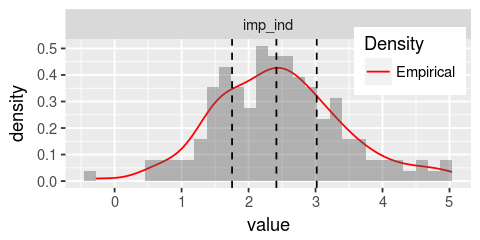

In [9]:
# This is ok for now, but some information about the standard deviatins should also be encoded.
# I'm uncertain what at this point, but distributional overlap seems important.
imp_ind <- (data$train['mu_go_14'] - data$train['mu_stop_14']) / data$train['sigma_go_14']
colnames(imp_ind) <- c('imp_ind')

options(repr.plot.width=4, repr.plot.height=2)
dmelt  <- melt(imp_ind, id.vars = NULL)

probs  <- c(0.25, 0.5, 0.75)
quants <- quantile(imp_ind, prob=probs, na.rm=TRUE)

ggplot(dmelt, aes(x = value)) +
   facet_wrap(~variable, scales = "free") +
   geom_line(aes(y = ..density.., colour = 'Empirical'), stat = 'density') +  
   geom_histogram(aes(y = ..density..), alpha = 0.4) +                        
   scale_colour_manual(name = 'Density', values = c('red', 'blue')) + 
   theme(legend.position = c(0.85, 0.85)) +
   geom_vline(data=dmelt, aes(xintercept=quants[1],), linetype="dashed", size=0.5) +
   geom_vline(data=dmelt, aes(xintercept=quants[2],), linetype="dashed", size=0.5) +
   geom_vline(data=dmelt, aes(xintercept=quants[3],), linetype="dashed", size=0.5)

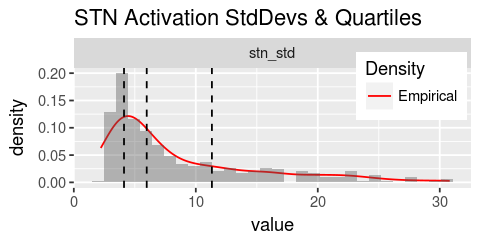

In [10]:
dmelt  <- melt(data$raw['stn_std'], id.vars = NULL)

probs  <- c(0.25, 0.5, 0.75)
stn_quants <- quantile(data$raw['stn_std'], prob=probs, na.rm=TRUE)

options(repr.plot.width=4, repr.plot.height=2)
ggplot(dmelt, aes(x = value)) +
   facet_wrap(~variable, scales = "free") +
   geom_line(aes(y = ..density.., colour = 'Empirical'), stat = 'density', na.rm=TRUE) +  
   geom_histogram(aes(y = ..density..), alpha = 0.4, bins=30, na.rm=TRUE) +                        
   scale_colour_manual(name = 'Density', values = c('red', 'blue')) + 
   theme(legend.position = c(0.85, 0.85)) +
   geom_vline(data=dmelt, aes(xintercept=stn_quants[1],), linetype="dashed", size=0.5) +
   geom_vline(data=dmelt, aes(xintercept=stn_quants[2],), linetype="dashed", size=0.5) +
   geom_vline(data=dmelt, aes(xintercept=stn_quants[3],), linetype="dashed", size=0.5) +
   ggtitle("STN Activation StdDevs & Quartiles")

## Mean Shift and Normalize  <a class="anchor" id="mean shift and normalize"></a> ##

In [11]:
# Just the continuous features though:
for (i in 1:n_feat_task_14){
    feature <- data$task_names_14[[i]]
    data$raw[feature] <- data$raw[feature] - colMeans(data$raw[feature], na.rm=TRUE)
    data$raw[feature] <- data$raw[feature] / apply(data$raw[feature], 2, sd, na.rm=TRUE)
}

## Shuffle Test <a class="anchor" id="Shuffle Test"></a> ## 
For making sure that everything below this fails to find anything significant when all the data gets randomized.

In [12]:
if (shuffle){
    dim(raw_df)
    # Need to exclude the age 18 survey features so their absence remains co-occurant.
    # Not doing so will "actually" break the data for the 14-18 CCA.
    # Shuffling for that test will need to be done at that time.
    cnames <- setdiff(colnames(raw_df), features_18_survey)
    for (i in 1:length(cnames)) {
        col  <- cnames[i]
        perm <- sample(1:dim(raw_df)[1], replace=TRUE)
        raw_df[col] <- raw_df[perm,col]
    }
}

## Missing Data: Age 14 <a class="anchor" id="missing data age 14"></a> ##

The missing data isn't uniformly distributed. Unfortunately, the output of md.pattern is a big table, which I can't figure out how to get displayed properly in Jupyter notebooks. But it gets created and saved below:

IQ_PR_14                 IQ_VC_14               GB_SSRT_14 agn_mean_corr_lat_neg_14 
                      16                       16                        0                       14 
agn_mean_corr_lat_pos_14      agn_num_omis_neg_14      agn_num_omis_pos_14       cgt_delay_avers_14 
                      14                       13                       13                       13 
            cgt_delib_14           cgt_quality_14          cgt_prop_bet_14       cgt_risk_adjust_14 
                      14                       13                       13                       29 
      cgt_risk_taking_14         prm_perc_corr_14                 rvp_a_14         swm_btwn_errs_14 
                      13                       10                       11                        8 
         swm_strategy_14              log10.k._14                 mu_go_14               mu_stop_14 
                       8                        1                       58                       57 
             sigma_go_14            sigma_stop_14                tau_go_14        mu_targ_dur_co_14 
                      58                       56                       56                       21 
      mu_targ_left_co_14        mu_rewarded_co_14   mu_high_rewarded_co_14                mu_int_14 
                      22                       21                       21                       21 
      sig_targ_dur_co_14      sig_targ_left_co_14       sig_rewarded_co_14  sig_high_rewarded_co_14 
                      21                       21                       21                       21 
                 stn_std 
                      48

IQ_PR_14                 IQ_VC_14               GB_SSRT_14 agn_mean_corr_lat_neg_14 
                      16                       17                        2                       18 
agn_mean_corr_lat_pos_14      agn_num_omis_neg_14      agn_num_omis_pos_14       cgt_delay_avers_14 
                      17                       13                       13                       14 
            cgt_delib_14           cgt_quality_14          cgt_prop_bet_14       cgt_risk_adjust_14 
                      14                       14                       14                       28 
      cgt_risk_taking_14         prm_perc_corr_14                 rvp_a_14         swm_btwn_errs_14 
                      14                        9                        6                        6 
         swm_strategy_14              log10.k._14                 mu_go_14               mu_stop_14 
                       6                        7                       57                       56 
             sigma_go_14            sigma_stop_14                tau_go_14        mu_targ_dur_co_14 
                      56                       56                       56                       21 
      mu_targ_left_co_14        mu_rewarded_co_14   mu_high_rewarded_co_14                mu_int_14 
                      22                       21                       21                       21 
      sig_targ_dur_co_14      sig_targ_left_co_14       sig_rewarded_co_14  sig_high_rewarded_co_14 
                      21                       21                       21                       21 
                 stn_std 
                      49

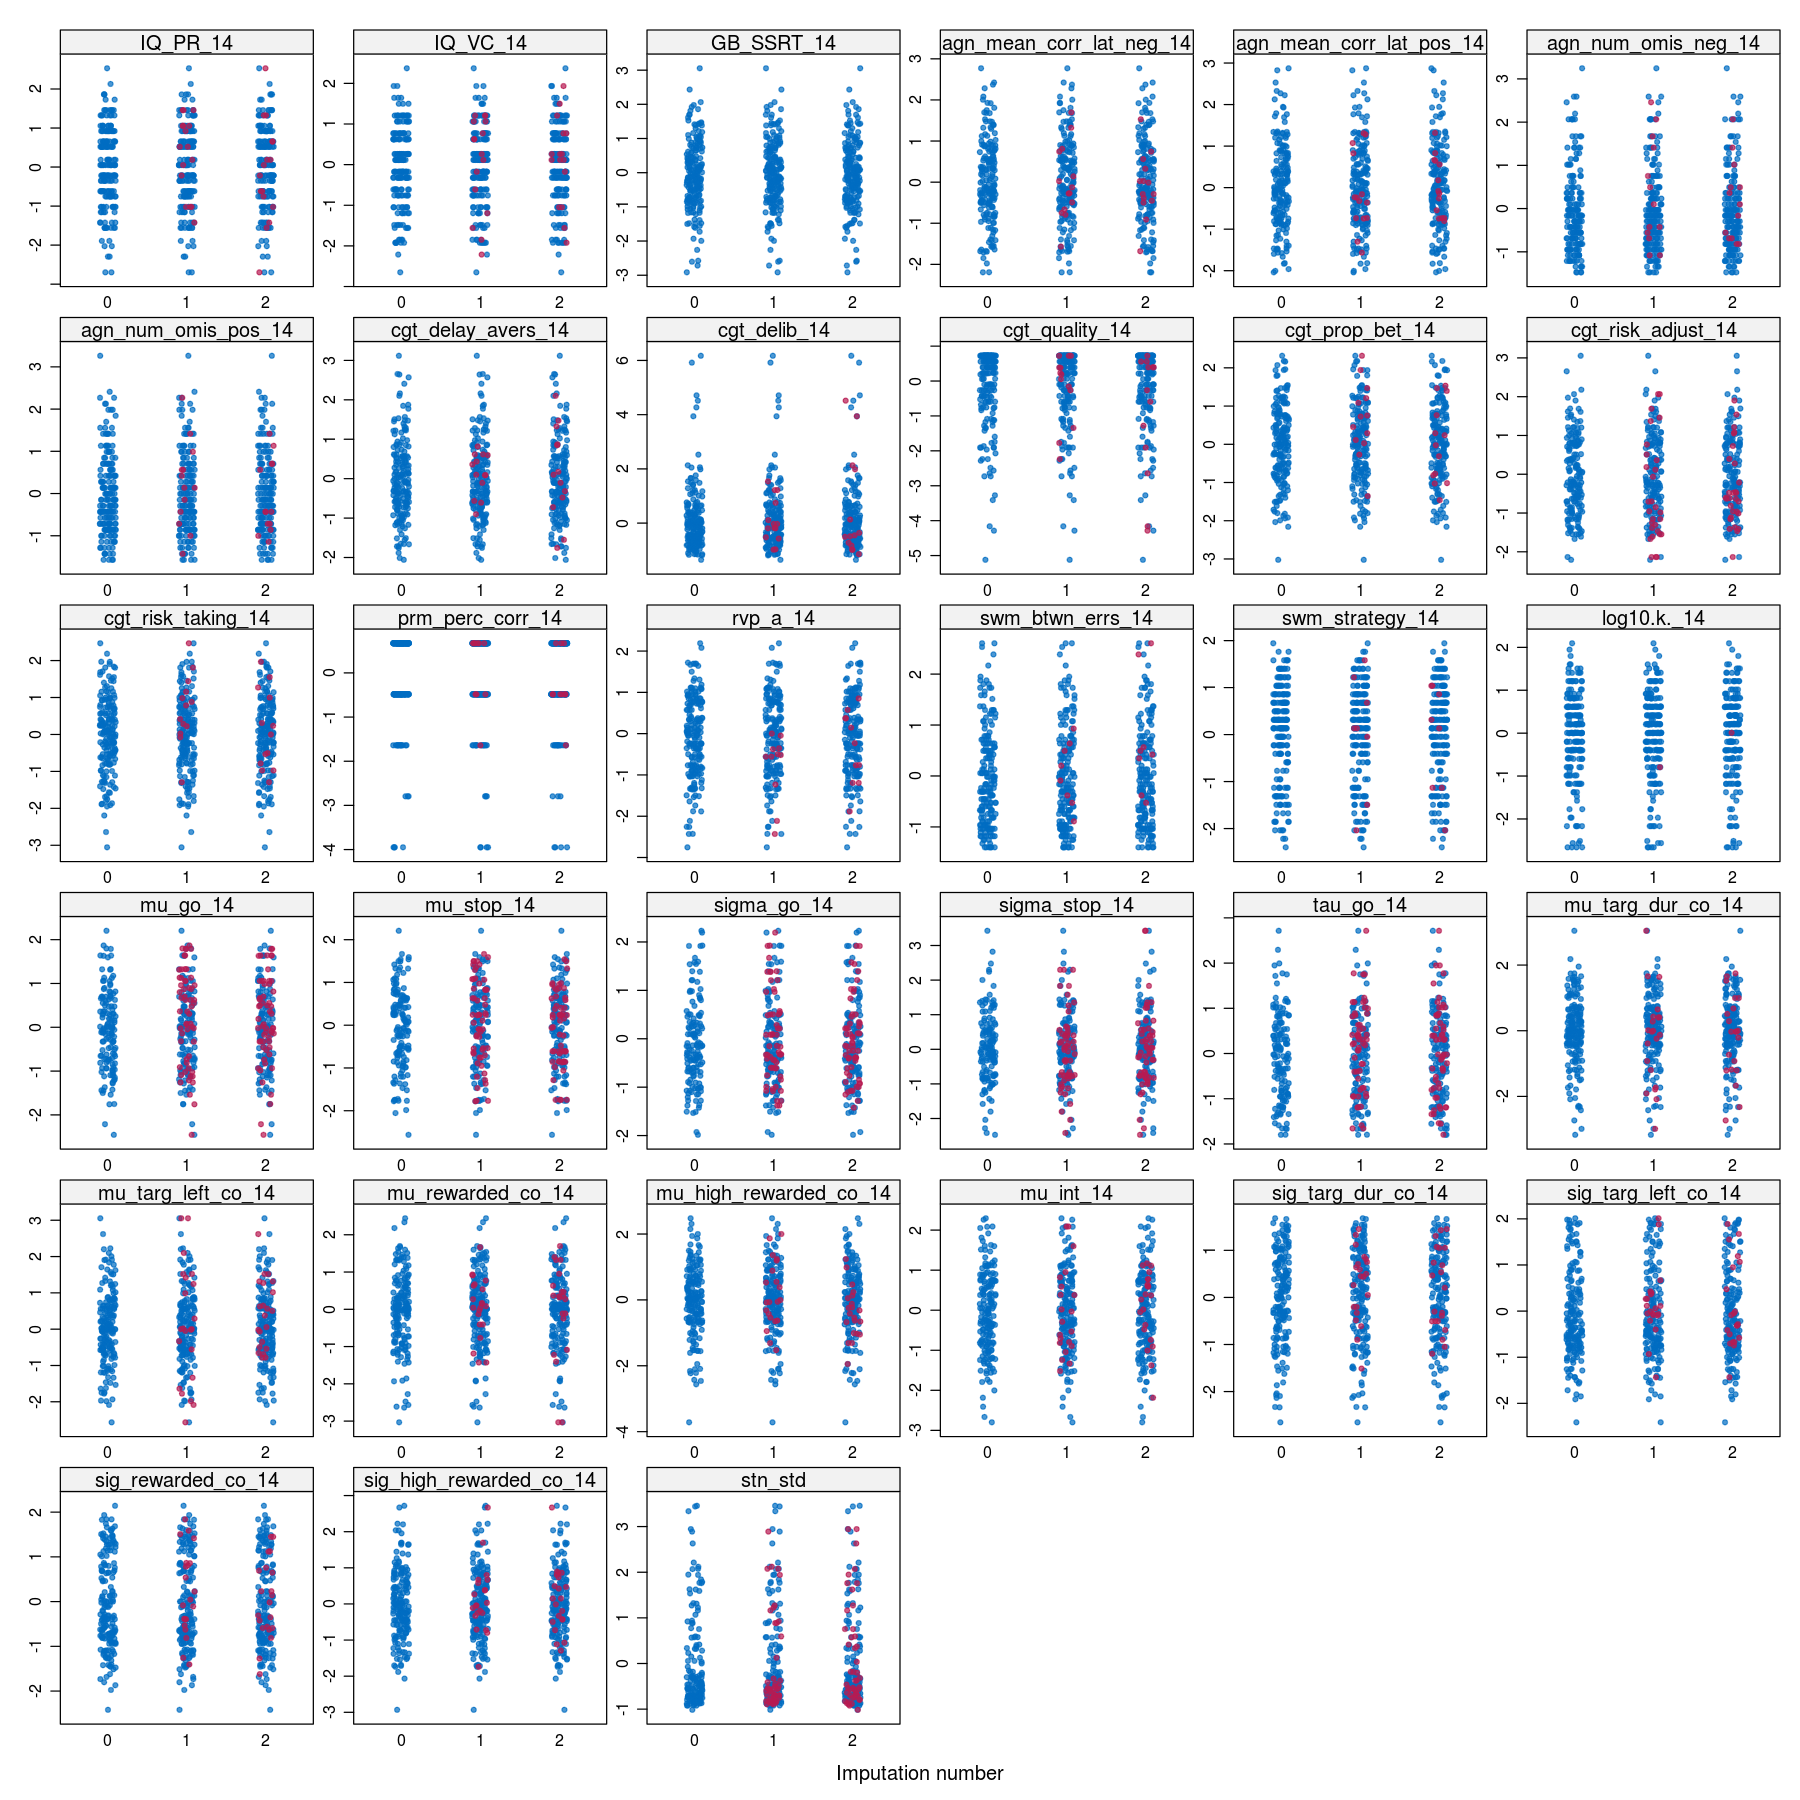

In [88]:
library(Rcpp)
library(mice)

# Display the number of missing values for each feature in train & test sets:
sapply(data$raw[data$task_names_14][data$train_inds,], function(x) sum(is.na(x)))
sapply(data$raw[data$task_names_14][data$test_inds,], function(x) sum(is.na(x)))

#---------------------------------------------------------------------#
#---                     This may take hours!                    -----#
#---------------------------------------------------------------------#
# Impute the features:
if (re_imp) {
    imp <- mice(data$raw[data$task_names_14][data$train_inds,], print = FALSE)
    imp <- mice(data$raw[data$task_names_14][data$train_inds,], pred = imp$predictorMatrix, seed=23109, m=30, maxit=1000, print = FALSE)
    saveRDS(imp,'imputed.rds')
} else{
    imp <- readRDS('imputed.rds')
}

#print(imp)
options(repr.plot.width=15, repr.plot.height=15)
stripplot(imp, pch = 20, cex = 0.75, subset = 1:(198*3))

## Impute Features: <a class="anchor" id="impute features"></a> ##
This uses a naive EM implementation from R-bloggers for continuous data and mean imputation w/ categorical data, (which should be fine for dealing with small numbers of subjects) and has the benefit (to me) of transparency.

In [ ]:
#missing_stats <- md.pattern(data$raw[data$task_names_14][data$train_inds,])
#missing_stats
#analysis_table_file <- '/home/dan/documents/lncc/synthetic data/sst_round_2/analysis_tables.csv'
#write.csv(missing_stats, file = analysis_table_file)

#get_missing_fracs <- function(data, ... ){
#    result <- sapply(data, function(x) sum(is.na(x))) / dim(data)[1] * 100
#    return(result)
#}

#options(repr.plot.width=7, repr.plot.height=7)

#data$raw
#dim(data$raw)
#par(mfrow=c(2,2), mai = c(2.6, 0.5, 0.5, 0.1))
#options(repr.plot.width=9, repr.plot.height=10)

#barplot(missing_tasks_14 , col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Task, 14')
#barplot(missing_survey_14, col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Survey, 14')
#barplot(missing_tasks_18 , col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Task, 18')
#barplot(missing_survey_18, col=c('red'), las=2, cex.axis=.7, ylab=c("Missing %"),  mgp=c(1.5,0.5,0), main='Survey, 18')


#source('em_imputation.r')
# Impute the task features:
#data_14_task.imputed <- em_imputation(data_14_task.raw, tol=.0001)

# Inverting a regression of alcohol and nicotine on the espad vars would be better...
# This shouldn't be too bad though.
#library(splines)
#library(foreach)
library(gam)

data_14_task.imputed   <- data_14_task.raw
data_14_survey.imputed <- data_14_survey.raw
data_14_survey.imputed
data_14_survey.imputed <- na.gam.replace(data_14_survey.raw)
data_14_survey.imputed <- round(data_14_survey.imputed)
colSums(data_14_survey.imputed != 0)


## Plot Finalized Data

In [ ]:
library(reshape2)
library(ggplot2)

options(repr.plot.width=9, repr.plot.height=5)

#d <- melt(data_14_task.imputed)
#ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_14_task.raw)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

#d <- melt(data_14_survey.raw)
#ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

d <- melt(data_18_survey.raw)
ggplot(d, aes(x = value)) + facet_wrap(~variable, scales = "free") + geom_histogram()

In [ ]:
# Creating imputed_df
# I must be missing something... R only hase merge for horiz. concat of data frames?
# And it requires the to-be-merged data frames to have an identical column on which to merge?
# Can there really be no horzcat()?

ncols_1 <- dim(data_14_task.imputed)[2]
ncols_2 <- dim(data_14_survey.imputed)[2]

nrows   <- dim(data_14_task.imputed)[1]

imputed_df <- data.frame(matrix(ncol=(ncols_1 + ncols_2), nrow=nrows))

imputed_df[,1:ncols_1]                     <- data_14_task.imputed
imputed_df[,(ncols_1+1):(ncols_1+ncols_2)] <- data_14_survey.imputed

colnames(imputed_df) <- c(colnames(data_14_task.imputed), colnames(data_14_survey.imputed))

dim(imputed_df)
dim(data_18_survey.raw)
#missing_imputed_df <- get_missing_fracs(imputed_df)

# Misc. Saved Snippets

In [ ]:
## This code was for verifying the equivalence of the redundant alc and nic fields
# msk <- data_14_survey.raw['All_Nic_14'] == data_14_survey.raw['espad_6.life.nic_14']
# data_14_survey.raw[!msk,'All_Nic_14']